<a href="https://colab.research.google.com/github/Dargel/AI_Rating_NER_comparison/blob/main/%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%82_1_2_%D0%94%D0%B0%D1%80%D0%B3%D0%B5%D0%BB%D1%8C_%D0%AE__%D0%9F%D0%BE%D0%B8%D1%81%D0%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Часть 2. Формирование рейтинга

Алгоритм:

1.   Проводим предобработку текста (без приведения к ниженму регистру): удаляем знаки препинания и стоп-слова на русском языке
2.   Находим слова, начинающиеся с большой буквы, и упомянутые в 1 публикации не менее 3 раз
3.   Лемматизируем кириллические названия
4.   Чистим список слов: убираем одушевленные существительные, географические названия, оставшиеся предлоги, местоимения; унифицируем варианты написания компаний
5. Ранжируем слова по частотности
6. Визуализируем рейтинг






In [1]:
#!pip install nltk
!pip install pymorphy3
#!pip install regex
#!pip install wordcloud

import os
import re
import pandas as pd

import nltk
from nltk import download
download('punkt_tab')
download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist

import pymorphy3
from pymorphy3 import MorphAnalyzer

from collections import Counter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 26.1 MB/s eta 0:00:00


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
df = pd.read_csv('AI_Comnews.csv') #загружаем собранный корпус статей
df

,date,title,text,link
0,25.12.2024,На Открытой конференции ИСП РАН 2024 обсудили ...,1500 участников собрала Открытая конференция И...,https://www.comnews.ru/content/237018/1018/
1,24.12.2024,"BIA Technologies: автоматизация, цифровые двой...","Развитие цифровых решений для логистики, торго...",https://www.comnews.ru/content/237017/1018/
2,24.12.2024,Киберэксперт Дмитрий Овчинников назвал топ-3 с...,В новогодние праздники мошенники традиционно а...,https://www.comnews.ru/content/237016/1018/
3,24.12.2024,Письмо Деду Морозу от редакции ComNews,Дорогой Дедушка Мороз! Пишет тебе редакция Com...,https://www.comnews.ru/content/236941/2024-12-...
4,23.12.2024,Экзоскелеты с искусственным интеллектом разраб...,"Компании ООО ""Экзо Солюшенс"" и ""Социальный код...",https://www.comnews.ru/digital-economy/content...
...,...,...,...,...
1468,19.01.2022,"Единый контакт-центр аптечной сети ""Ригла"" объ...",NAUMEN завершил работы по созданию единого кон...,https://www.comnews.ru/content/218353
1469,14.01.2022,Совершенствование систем удаленной работы прод...,"Как отмечают в Lenovo, удаленный режим работы ...",https://www.comnews.ru/content/218259/2022-01-...
1470,13.01.2022,Рынок СХД в тисках жизненного цикла,"Такие данные приводят ""Т1 Интеграция"", Huawei ...",https://www.comnews.ru/content/218243
1471,12.01.2022,"ИИ предсказал, где новые лекарства смогут подо...",Научная группа iMolecule из Сколтеха разработа...,https://www.comnews.ru/digital-economy/content...


In [5]:
# Выполняем предобработку и находим слова, начинающиеся с заглавной буквы

def up_words(text):
  names = []
  uppers = []
  stop_words = stopwords.words('russian')
  morph = MorphAnalyzer()
  text_no_punkt = re.sub('[^\w\d -]', '', text) #удаляем пунктуацию
  text_list_nltk = word_tokenize(text_no_punkt) #токенизируем
  text_clean = [word for word in text_list_nltk if word not in stop_words and word[0].isalpha()] #удаляем стоп-слова и "мусор"
  for word in text_clean:
    if word[0].isupper(): #находим слова с первой загловной буквой
      lemm = morph.parse(word)[0].normal_form #лемматизируем
      names.append(lemm)
  word_frequencies = FreqDist(names) #считаем частоту
  for token, frequency in word_frequencies.items():
    if frequency >= 3: #если частота больше 3, предполагаем, что слово может нам подойти
      uppers.append(token)
  return uppers

In [6]:
df['uppers'] = df['text'].apply(up_words) #создаем новый столбец с выбранныи леммами
df

,date,title,text,link,uppers
0,25.12.2024,На Открытой конференции ИСП РАН 2024 обсудили ...,1500 участников собрала Открытая конференция И...,https://www.comnews.ru/content/237018/1018/,"[исп, ран, академия, рф, в, дмитрий, россия, и..."
1,24.12.2024,"BIA Technologies: автоматизация, цифровые двой...","Развитие цифровых решений для логистики, торго...",https://www.comnews.ru/content/237017/1018/,"[кроме, bia, technologies]"
2,24.12.2024,Киберэксперт Дмитрий Овчинников назвал топ-3 с...,В новогодние праздники мошенники традиционно а...,https://www.comnews.ru/content/237016/1018/,"[дмитрий, овчинник, мошенник]"
3,24.12.2024,Письмо Деду Морозу от редакции ComNews,Дорогой Дедушка Мороз! Пишет тебе редакция Com...,https://www.comnews.ru/content/236941/2024-12-...,"[дедушка, мороз, в, ия, дед, но]"
4,23.12.2024,Экзоскелеты с искусственным интеллектом разраб...,"Компании ООО ""Экзо Солюшенс"" и ""Социальный код...",https://www.comnews.ru/digital-economy/content...,[социальный]
...,...,...,...,...,...
1468,19.01.2022,"Единый контакт-центр аптечной сети ""Ригла"" объ...",NAUMEN завершил работы по созданию единого кон...,https://www.comnews.ru/content/218353,"[naumen, ригла, в]"
1469,14.01.2022,Совершенствование систем удаленной работы прод...,"Как отмечают в Lenovo, удаленный режим работы ...",https://www.comnews.ru/content/218259/2022-01-...,"[как, lenovo, например, iva, виктор, петров, в..."
1470,13.01.2022,Рынок СХД в тисках жизненного цикла,"Такие данные приводят ""Т1 Интеграция"", Huawei ...",https://www.comnews.ru/content/218243,"[huawei, схд, ispsystem, десятников, это, ssd,..."
1471,12.01.2022,"ИИ предсказал, где новые лекарства смогут подо...",Научная группа iMolecule из Сколтеха разработа...,https://www.comnews.ru/digital-economy/content...,"[сколтех, рнк, днк, попов]"


Дальше нужно отсеять как можно больше неподходящих кириллических слов, поэтому было решено использовать другой лемматизатор - Mystem, у которого шире возможности грамматической разметки для русского языка.

In [7]:
from pymystem3 import Mystem  #грамматическая разметка предобработанного текста
morph = Mystem()


Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [8]:
text_mystem = morph.analyze(str(df['uppers'].to_list()))

text_mystem

[{'text': "[['"},
 {'analysis': [{'lex': 'исп',
    'wt': 0.5449043416,
    'qual': 'bastard',
    'gr': 'S,муж,неод=(вин,ед|им,ед)'}],
  'text': 'исп'},
 {'text': "', '"},
 {'analysis': [{'lex': 'ран',
    'wt': 0.5947859538,
    'gr': 'S,ед,жен,неод=(пр|вин|дат|род|твор|им)'}],
  'text': 'ран'},
 {'text': "', '"},
 {'analysis': [{'lex': 'академия', 'wt': 1, 'gr': 'S,жен,неод=им,ед'}],
  'text': 'академия'},
 {'text': "', '"},
 {'analysis': [{'lex': 'рф',
    'wt': 1,
    'gr': 'S,сокр,гео,ед,жен,неод=(пр|вин|дат|род|твор|им)'}],
  'text': 'рф'},
 {'text': "', '"},
 {'analysis': [{'lex': 'в', 'wt': 0.9999917878, 'gr': 'PR='}], 'text': 'в'},
 {'text': "', '"},
 {'analysis': [{'lex': 'дмитрий', 'wt': 1, 'gr': 'S,имя,муж,од=им,ед'}],
  'text': 'дмитрий'},
 {'text': "', '"},
 {'analysis': [{'lex': 'россия', 'wt': 1, 'gr': 'S,гео,жен,неод=им,ед'}],
  'text': 'россия'},
 {'text': "', '"},
 {'analysis': [{'lex': 'ия', 'wt': 1, 'gr': 'S,имя,жен,од=им,ед'}],
  'text': 'ия'},
 {'text': "', '"},

Создадим списки слов, которые нам точно не подходят

In [9]:
#собираем список одушевленных сущ и географичексих названий
names = []
#при анализе первичного списка выяснилось, что нужно внести исключения:
exceptions = ['сбер', 'сберсити', 'сберкорус', 'авить', 'нейролаб', 'касперский', 'сегежа', 'рольф', 'спортмастер', 'эвотор', 'протей' , 'ростсельмаш', 'адамас', 'биорг', 'ригла', 'русал', 'сбераналитик', 'геоскан', 'нэксайн', 'рослесинфорг',  'ростёха', 'уралхий', 'гринат', 'мисис', 'гринатом', 'росатом', 'технониколь', 'ютэйр', 'русгидро']
for word in text_mystem:
  if word['text'] not in exceptions:
    if word.get('analysis'):
      if ',од=' in word['analysis'][0]['gr'] or 'гео' in word['analysis'][0]['gr']:
        names.append(word['text'])
print(names)


['рф', 'дмитрий', 'россия', 'ия', 'евгений', 'дмитрий', 'овчинник', 'мошенник', 'дедушка', 'ия', 'дед', 'ия', 'ия', 'екатерина', 'коныгин', 'максим', 'жаров', 'иван', 'беляков', 'ия', 'россия', 'россия', 'ия', 'ия', 'рид', 'сергей', 'ия', 'мартынов', 'россия', 'ципр', 'китай', 'председатель', 'рф', 'дмитрий', 'нейротрейдер', 'босенко', 'ия', 'злоумышленник', 'россия', 'президент', 'ия', 'андрей', 'ии', 'агент', 'ия', 'владимир', 'путин', 'ия', 'россия', 'нг', 'лидер', 'ия', 'владимир', 'москва', 'россия', 'сергей', 'ано', 'александр', 'ленобласть', 'антон', 'владислав', 'россия', 'ия', 'россия', 'президент', 'ия', 'александр', 'москва', 'сапсан', 'санкт-петербург', 'алексей', 'павел', 'владимир', 'александр', 'лань', 'россия', 'андрей', 'михаил', 'антон', 'ит', 'ред', 'ит', 'евгений', 'юлия', 'цикада', 'анастасия', 'ия', 'георгий', 'тарасов', 'ия', 'артём', 'дмитрий', 'марков', 'новгород', 'друг', 'ия', 'ии', 'ия', 'индонезия', 'азия', 'ит', 'ия', 'россия', 'ия', 'ия', 'ия', 'робот', '

In [10]:
# смотрим, какие служебные части речи и прилагательные еще остались
pr_list = [] #при анализе первичного списка также выяснилось, что нужно внести исключения:
exceptions_pr = ['мвидео', 'росатом', 'сколково', 'евраз', 'сеченовский']
for word in text_mystem:
   if word['text'] not in exceptions_pr:
    if word.get('analysis'):
      if word['analysis'][0]['gr'].startswith('PR') or word['analysis'][0]['gr'].startswith('CONJ') or word['analysis'][0]['gr'].startswith('SPRO') or word['analysis'][0]['gr'].startswith('A'):
        pr_list.append(word['text'])
print(pr_list)

['в', 'по', 'и', 'кроме', 'в', 'но', 'социальный', 'это', 'в', 'но', 'первый', 'битый', 'мы', 'при', 'по', 'ленинградский', 'по', 'он', 'по', 'интеллектуальный', 'она', 'вы', 'в', 'по', 'а', 'электронный', 'в', 'цифровой', 'нижегородский', 'на', 'за', 'в', 'этот', 'она', 'в', 'российский', 'и', 'национальный', 'российский', 'липецкий', 'тюменский', 'цифровой', 'цифровой', 'ленинградский', 'в', 'он', 'по', 'российский', 'российский', 'хабаровский', 'центральный', 'хороший', 'в', 'цифровой', 'транспортный', 'мы', 'федеральный', 'наш', 'большой', 'белгородский', 'по', 'санкт-петербургский', 'для', 'информационный', 'самый', 'и', 'я', 'этот', 'например', 'если', 'это', 'ваш', 'современный', 'по', 'поэтому', 'они', 'в', 'мобильный', 'нижний', 'мы', 'в', 'в', 'в', 'в', 'конечно', 'сахалинский', 'как', 'в', 'в', 'в', 'но', 'по', 'он', 'по', 'это', 'магистральный', 'в', 'полярный', 'российский', 'кроме', 'вы', 'при', 'такой', 'пропускной', 'какой', 'с', 'и', 'мы', 'данный', 'оптиковолоконный',

In [11]:
#этот список был сформированы вручную после анализа первых результатов: удалено все, что не является брендом/название компании
#при использовании функции uppers_clean (см ниже)
exclude = ['ооо', 'ао', 'пао', 'гк', 'оао', 'ai', 'comnews', 'центр','chatgpt','минцифра', 'иб','ассоциация','ит-компания','федерация','правительство','группа','фонд','ит-специалист', 'университет','компания','llm','форум', 'group', 'cloud', 'engines', 'сезон', 'technologies', 'система', 'ит-решение', 'банк', 'data', 'технология', 'ит-инфраструктура', 'цифра',
 'gigachat', 'microsoft', 'google', 'гис', 'sap', 'экономика', 'ос', 'республика', 'ии-решение', 'кодекс', 'роман', 'институт', 'платформа', 'цод', 'апк', 'эпр', 'известие', 'лаборатория', 'digital', 'hr', 'госдума', 'тэк', 'проект', 'департамент', 'финтех', 'гост', 'gpt', 'госкорпорация', 'министерство', 'минэкономразвития', 'paas', 'решение', 'интернет', 'почта', 'telecom', 'iot', 'жкх', 'альянс', 'vision', 'security', 'ук', 'gpu', 'госуслуга', 'days', 'ии-технология', 'iaas', 'big', 'openai', 'есть', 'роскомнадзор', 'раэк', 'rpa','пд', 'не', 'холдинг', 'контакт-центр', 'инфосистема', 'монитор', 'it', 'брикс', 'ngfw', 'пак', 'концерн', 'развитие', 'цифровизация', 'devops', 'абд', 'ит-рынок', 'вкс', 'р', 'id']
print(len(exclude))


105


In [12]:
#функция "очистки брендов"
def uppers_clean(text):
  pseudo_brands =[]
  for word in text:
    if word not in names and word not in pr_list and word not in exclude:
      pseudo_brands.append(word)
  return pseudo_brands


In [13]:
df['uppers_new'] = df['uppers'].apply(uppers_clean) #создаем новый столбец с очищенным списком брендов
df

,date,title,text,link,uppers,uppers_new
0,25.12.2024,На Открытой конференции ИСП РАН 2024 обсудили ...,1500 участников собрала Открытая конференция И...,https://www.comnews.ru/content/237018/1018/,"[исп, ран, академия, рф, в, дмитрий, россия, и...","[исп, ран, академия]"
1,24.12.2024,"BIA Technologies: автоматизация, цифровые двой...","Развитие цифровых решений для логистики, торго...",https://www.comnews.ru/content/237017/1018/,"[кроме, bia, technologies]",[bia]
2,24.12.2024,Киберэксперт Дмитрий Овчинников назвал топ-3 с...,В новогодние праздники мошенники традиционно а...,https://www.comnews.ru/content/237016/1018/,"[дмитрий, овчинник, мошенник]",[]
3,24.12.2024,Письмо Деду Морозу от редакции ComNews,Дорогой Дедушка Мороз! Пишет тебе редакция Com...,https://www.comnews.ru/content/236941/2024-12-...,"[дедушка, мороз, в, ия, дед, но]",[мороз]
4,23.12.2024,Экзоскелеты с искусственным интеллектом разраб...,"Компании ООО ""Экзо Солюшенс"" и ""Социальный код...",https://www.comnews.ru/digital-economy/content...,[социальный],[]
...,...,...,...,...,...,...
1468,19.01.2022,"Единый контакт-центр аптечной сети ""Ригла"" объ...",NAUMEN завершил работы по созданию единого кон...,https://www.comnews.ru/content/218353,"[naumen, ригла, в]","[naumen, ригла]"
1469,14.01.2022,Совершенствование систем удаленной работы прод...,"Как отмечают в Lenovo, удаленный режим работы ...",https://www.comnews.ru/content/218259/2022-01-...,"[как, lenovo, например, iva, виктор, петров, в...","[lenovo, iva, trueconf, црт]"
1470,13.01.2022,Рынок СХД в тисках жизненного цикла,"Такие данные приводят ""Т1 Интеграция"", Huawei ...",https://www.comnews.ru/content/218243,"[huawei, схд, ispsystem, десятников, это, ssd,...","[huawei, схд, ispsystem, ssd, hdd, enterprise,..."
1471,12.01.2022,"ИИ предсказал, где новые лекарства смогут подо...",Научная группа iMolecule из Сколтеха разработа...,https://www.comnews.ru/digital-economy/content...,"[сколтех, рнк, днк, попов]","[сколтех, рнк, днк]"


In [17]:
#наводим порядок с разным написанием одних и тех же брендов/компаний
brands = []
for group in df['uppers_new']:
  for word in group:
    if "сбер" in word:
      word = 'сбер'
    if "mts" in word:
      word = 'мтс'
    if "yandex" in word:
      word = 'Яндекс'
    if "авить" in word or 'Avito' in word:
      word = 'Авито'
    if "мегафон" in word:
      word = 'Мегафон'
    if "русало" in word:
      word = 'Русал'
    if "iva" in word:
      word = 'Iva Technologies'
    if "beorg" in word:
      word = 'Биорг'
    if "вымпелком" in word:
      word = 'билайн'
    if "нти" in word:
      word = 'Фонд НТИ'
    if "positive" in word:
      word = 'Positive Technologies'
    if "vk" in word:
      word = 'ВКонтакте'
    if "smart" in word:
      word = 'Smart Engines'
    if "х5" in word:
      word = 'X5'
    if "гпб" in word:
      word = 'Газпромбанк'
    if "мвидео" in word:
      word = 'М.Видео-Эльдорадо'
    if "тиньк" in word or "т-банк" in word:
      word = 'Т-Банк'
    if "гринат" in word:
      word = 'Гринатом'
    if "ростёх" in word or "ростех" in word:
      word = 'Ростех'
    if "сеченовский" in word or "ростех" in word:
      word = 'Сеченовский Университет'
    word = word[0].upper() + word[1:] #заодно вернем им первую заглавную букву
    if len(word)<=3: #а названия из 3 букв сделаем полностью капсом
      word = word.upper()
    brands.append(word)
print(brands)


['ИСП', 'РАН', 'Академия', 'BIA', 'Мороз', 'Магнит', 'Remez', 'М.Видео-Эльдорадо', 'Rpa-платформа', 'Ideco', 'Skydns', 'DGA', 'ГСМ', 'Биорг', 'Тнг-группа', 'ФАС', 'Фонд НТИ', 'Билайн', 'LTE', 'МТС', 'МТС', 'Youtube', 'Rutube', 'Удача', 'Nvidia', 'Intelligence', 'IDC', 'СМИ', 'URL', 'Worldwide', 'Artificial', 'Corp', 'Reach', 'Spending', 'Точка', 'Ё-такси', 'Exodrive', 'Visionlabs', 'Q-systems', 'Cloudru', 'Evolution', 'Атака', 'Ииэтап', 'Ии-агент', 'Journey', 'Фонд НТИ', 'Cloudru', 'Ai-сервис', 'Убрир', 'Биорг', 'Премия', 'ГБУ', 'ЛО', 'МФЦ', 'Яндекс', 'Святик', 'ИСП', 'РАН', 'Т-технология', 'T-pro', 'T-lite', 'Mera', 'RU', 'Arena', 'Hard', 'MT', 'Bench', 'Модель', 'Русал', 'Краз', 'Membrana', 'Kids', 'МТС', 'Future', 'Crew', 'Авантелек', 'Airi', 'Горбанить', 'X-com', 'Sberdevices', 'Awards', 'Транстелек', 'Награда', 'Спасибо', 'Аврора', 'Русагро', 'ВКонтакте', 'Tech', 'Мойофис', 'Gorodpay', 'Газпромбанк', 'Сервис', 'SL', 'Soft', 'Robin', 'Knowledge', 'Space', 'Русал', 'Газпром', 'Софт'

In [22]:
#Формируем рейтинг

AI_rating = FreqDist(brands)
AI_rating.most_common(57)

# 5 и более публикаций у 57 компаний.
#Нижние строчки (1-4 публ) не показательны, поэтому не вычищались


[('Сбер', 80),
 ('МТС', 52),
 ('Яндекс', 41),
 ('Smart Engines', 30),
 ('Ростелеком', 24),
 ('Биорг', 23),
 ('BSS', 22),
 ('Сколково', 20),
 ('Газпром', 18),
 ('ВТБ', 15),
 ('ВКонтакте', 14),
 ('Росатом', 14),
 ('Visionlabs', 12),
 ('Сибур', 12),
 ('ЦРТ', 12),
 ('Билайн', 11),
 ('Iva Technologies', 11),
 ('Авито', 11),
 ('Рдтех', 10),
 ('Ntechlab', 9),
 ('Мегафон', 9),
 ('X5', 9),
 ('РАН', 8),
 ('Фонд НТИ', 8),
 ('Русал', 8),
 ('Мойофис', 8),
 ('Т-Банк', 8),
 ('Telegram', 8),
 ('Т1', 8),
 ('Самолёт', 8),
 ('Сеченовский Университет', 7),
 ('РЖД', 7),
 ('Рексофт', 7),
 ('Россельхозбанк', 7),
 ('ВШЭ', 7),
 ('Магнит', 6),
 ('Cloudru', 6),
 ('Русагро', 6),
 ('Газпромбанк', 6),
 ('К2тех', 6),
 ('Нлмк', 6),
 ('Гринатом', 6),
 ('MCN', 6),
 ('Positive Technologies', 6),
 ('Альфа-банк', 6),
 ('IBS', 6),
 ('Сколтех', 6),
 ('М.Видео-Эльдорадо', 5),
 ('Иннополис', 5),
 ('Норникель', 5),
 ('Газинформсервис', 5),
 ('МГУ', 5),
 ('Nexign', 5),
 ('Ростех', 5),
 ('Касперский', 5),
 ('Softlogic', 5),
 ('Д

Визуализация рейтинга

<Axes: title={'center': 'ТОП-20 ИИ-брендов'}, xlabel='Samples', ylabel='Counts'>

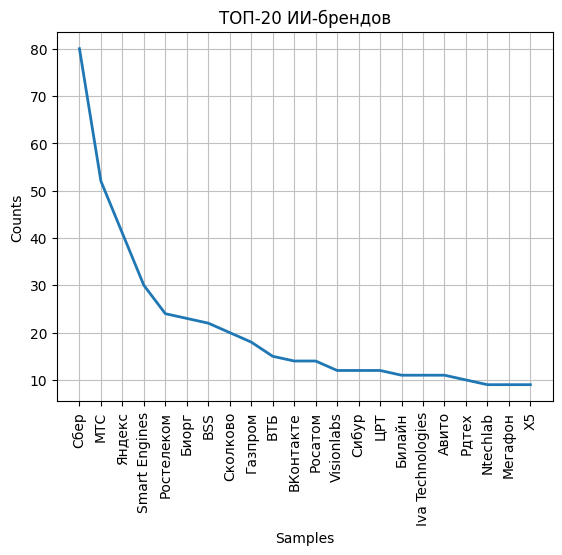

In [24]:
AI_rating.plot(22, title='ТОП-20 ИИ-брендов') #те, у кого 9+ публикаций

In [ ]:
comp = []
freq = []
for token, frequency in AI_rating.items():
  if frequency >= 9: #визуализируем тех, у кого от 9 публикаций (22 компании)
    comp.append(token)
    freq.append(frequency)
top = dict(zip(comp, freq))
print(top)

{'Биорг': 23, 'Билайн': 11, 'МТС': 52, 'Visionlabs': 12, 'Яндекс': 41, 'ВКонтакте': 14, 'Газпром': 18, 'Сбер': 80, 'Iva Technologies': 11, 'Сколково': 20, 'Ntechlab': 9, 'ВТБ': 15, 'Ростелеком': 24, 'Мегафон': 9, 'Росатом': 14, 'Сибур': 12, 'Smart Engines': 30, 'BSS': 22, 'Рдтех': 10, 'ЦРТ': 12, 'X5': 9, 'Авито': 11}


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


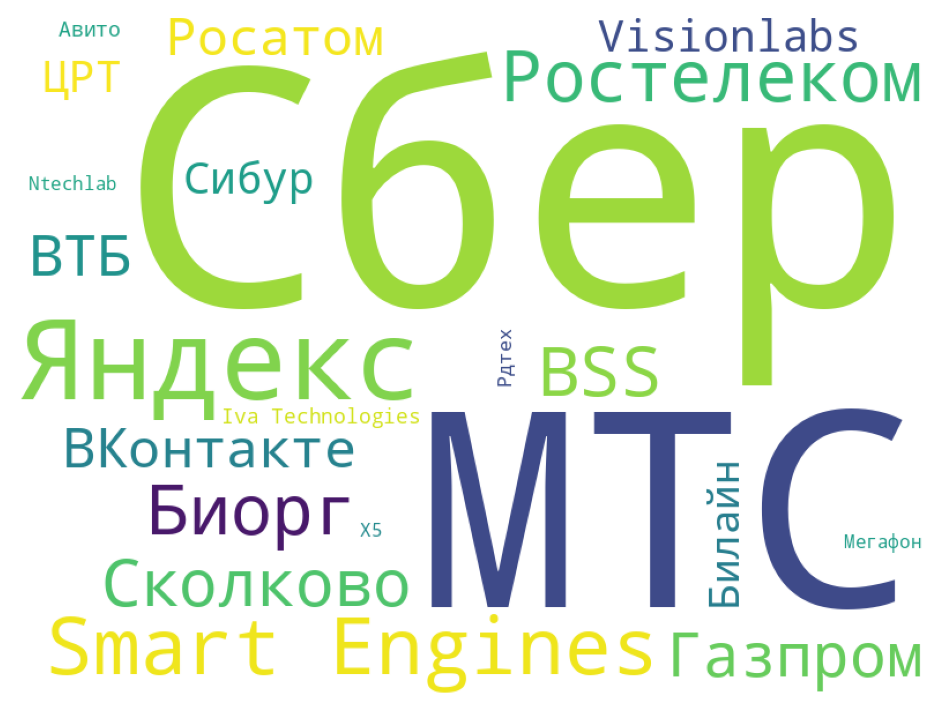

In [ ]:
wordcloud = WordCloud(margin = 15,
                      width = 800,
                      height = 600,
                      background_color='white',
                      colormap='viridis').generate_from_frequencies(top)
plt.figure(figsize=(12, 9))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
#сохраняем картинку
wordcloud.to_file('AI_TOP.png')